一.CIFAR-10数据集下载

1.导入相关使用到的库。

In [26]:
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
import time

2.加载数据集。这里有可能加载的时候速度非常慢，所以有另一个解决方法就是直接点击https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 
下载，迅雷下载的速度会快一点，下载完直接将文件复制到当前环境目录，keras/datasets的中，然后把文件的名字改为cifar-10-batches-py.tar.gz即可。

In [27]:
(x_train,y_train),(x_test,y_test) = tf.keras.datasets.cifar10.load_data()

二.CIFAR-10数据集的查看

1.查看图片数量和大小。因为这里的图像已经是彩色图像了，因此第四维的值为3。

In [28]:
print(len(x_train))
print(len(x_test))
print(x_train.shape)

50000
10000
(50000, 32, 32, 3)


2.查看图片单个点信息。因为是彩色图片，所以单个点的信息包含R、G、B三个颜色通道的值。



In [29]:
# 第一个[0]代表取50000张图片中的第一张，第二个[0]代表取第一行，第三个[0]代表取第一列
x_train[0][0][0]

array([59, 62, 63], dtype=uint8)

3.定义数字对应类别的字典，因为我们训练时的标签是0-9，要映射成对应的类别名称显示。

In [30]:
label_dict={0:'airplane',1:'automobile',2:'bird',3:'cat',4:'deer',5:'dog',6:'frog',7:'horse',8:'ship',9:'truck'}

4.定义显示图片函数并显示图片，该函数和第一节大体一样，有小部分需要修改一下。

In [31]:
def plot_images_labels_prediction(images,labels,prediction,idx,num=10):
    fig=plt.gcf()
    fig.set_size_inches(12,14)
    if num>25: num=25
    for i in range(0,num):
        ax = plt.subplot(5,5,i+1)
        ax.imshow(images[idx],cmap='binary') 
        title= str(i)+' '+label_dict[labels[i][0]]   #显示数字对应的类别
        if len(prediction)>0:
            title+= '=>'+label_dict[prediction[i]]   #显示数字对应的类别
        ax.set_title(title,fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        idx+=1
    plt.show()

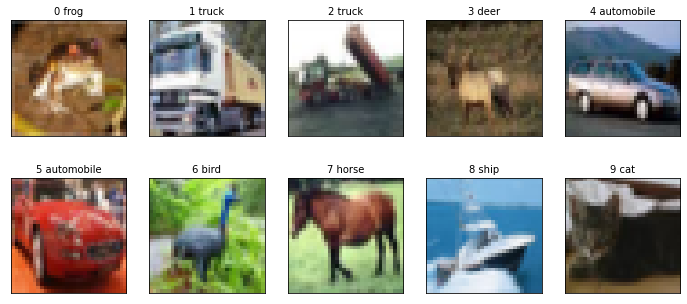

In [32]:
plot_images_labels_prediction(x_train,y_train,[],0)

三.CIFAR-10数据集的预处理

1.数据标准化并查看一个点的值。

In [33]:
x_train_normalize = x_train.astype('float32')/255.0
x_test_normalize = x_test.astype('float32')/255.0

In [34]:
print(x_train_normalize[0][0][0])

[0.23137255 0.24313726 0.24705882]


2.对标签进行One-Hot（独热编码）。

In [35]:
y_train_OneHot = tf.keras.utils.to_categorical(y_train)
y_test_OneHot = tf.keras.utils.to_categorical(y_test)

四.模型搭建

1.这里搭建3层卷积神经网络提取特征，之后在进行训练。

In [36]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',input_shape=(32,32,3),activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),padding='same',activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(2500,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1500,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(10,activation='softmax'))

2.打印模型概要。


In [37]:
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_6 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)       

3.模型参数设置。

In [38]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

4.模型训练，为了节省时间这边只训练了5次。

In [39]:
t_start = time.time()
train_history=model.fit(x_train_normalize,y_train_OneHot,validation_split=0.2,epochs=5,batch_size=128,verbose=1)
t_end = time.time()
print ("time cost: %5.2f ms" % ((t_end - t_start) * 1000)) 

Epoch 1/5
313/313 [==============================] - 9s 30ms/step - loss: 1.8244 - accuracy: 0.3183 - val_loss: 1.7231 - val_accuracy: 0.3575

5.定义曲线显示函数并显示（和前两节的一样）。

In [40]:
def show_train_history(train_history,train,validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title('Train History')
    plt.xlabel('epoch')
    plt.ylabel(train)
    plt.legend(['train','validation'],loc='upper left')


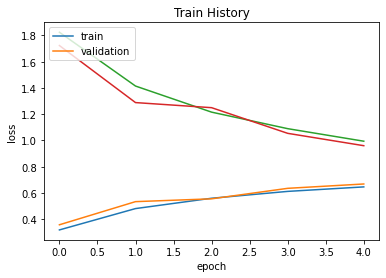

In [41]:
show_train_history(train_history,'accuracy','val_accuracy')
show_train_history(train_history,'loss','val_loss')

五.模型测试及预测

1.测试集进行测试。

In [42]:
scores = model.evaluate(x_test_normalize,y_test_OneHot,verbose=2)
print(scores[1])

313/313 - 1s - loss: 0.9747 - accuracy: 0.6599
0.6599000096321106


2.模型预测。

In [43]:
prediction = model.predict_classes(x_test_normalize)
print(prediction)

[3 8 8 ... 5 4 7]


3.调用之前定义的plot_images_labels_prediction函数查看具体图片信息和结果。

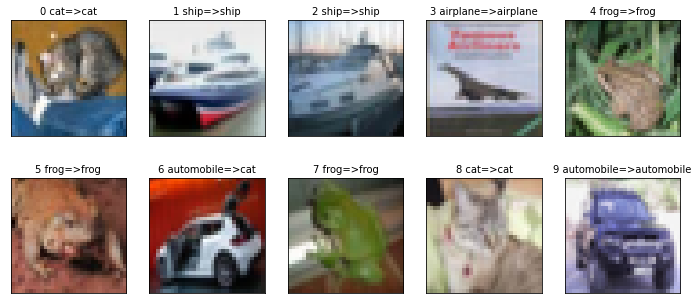

In [44]:
plot_images_labels_prediction(x_test,y_test,prediction,0,10)

4.keras的model.predict_classes是用于直接预测出类别结果，如果我们想知道预测图片分别对应10个类别的概率，我们可以用model.predict来进行查看。

In [45]:
prediction_probability = model.predict(x_test_normalize)
print(prediction_probability[0])

[0.00186376 0.00103709 0.01503416 0.7788157  0.00621179 0.14119953
 0.02918432 0.0074386  0.01743458 0.00178044]


这里的10个数字代表的预测图片对应识别成10个类别的概率。

5.我们可以定义一个图片+预测概率的函数，方便查看预测概率结果。


In [46]:
def show_predicted_probability(x,y,prediction,prediction_probability,i):
    print("label:",label_dict[y[i][0]],'predict,',label_dict[prediction[i]])
    plt.figure(figsize=(2,2))
    plt.imshow(x[i])
    plt.show()
    for j in range(10):          #输出10个类别概率
        print(label_dict[j]+'Probability:%1.9f'%(prediction_probability[i][j]))

6.使用pandas的crosstab函数查看混淆矩阵。这里要注意的是pandas.crosstab的输入必须是一维数组，所以传入的prediction和测试集的label都需要是一维的，如果不是一维数组，需要用reshape转为一维数组。

In [47]:
print(prediction.shape)
print(y_test.shape)

(10000,)
(10000, 1)


我们发现测试集的标签不是一维数组，因此我们需要使用reshape(-1)去转换，这里的reshape（-1）就是将数据平铺展开成了一维数组。之后传入函数，发现运行成功。

In [48]:
pd.crosstab(y_test.reshape(-1),prediction,rownames=['label'],colnames=['prediction'])

prediction,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,674,17,40,49,49,8,11,13,92,47
1,17,755,3,18,18,7,30,8,22,122
2,67,1,449,94,182,59,101,29,13,5
3,10,3,45,510,90,154,138,33,8,9
4,23,2,44,71,696,19,81,59,4,1
5,3,0,41,242,99,520,55,34,3,3
6,2,1,23,56,87,13,809,4,5,0
7,11,0,24,69,144,59,29,653,1,10
8,70,33,23,51,6,10,10,5,766,26


六.模型保存和加载

1.训练完模型之后我们可以用model.save_weights对模型进行保存，可以保存成h5格式的，如果出现保存失败，可能原因是你电脑里没有安装h5py这个东西或是版本不匹配直接卸载再安装即可，在anaconda prompt中输入pip install h5py就好了。

In [49]:
model.save_weights("cifar.h5")

2.如果要加载一个已经训练好的模型的参数，则用load_weights进行读取.

In [50]:
model.load_weights("cifar.h5")